### Which Countries Are Cutting CO₂ Emissions Per Capita?

This notebook uses the Our World in Data CO₂ and greenhouse gas emissions dataset to find which countries have made the biggest strides in reducing CO₂ emissions per person over roughly the last 15 years, and how this relates to changes in coal, oil, gas and energy use.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

RAW_URL = "https://raw.githubusercontent.com/owid/co2-data/refs/heads/master/owid-co2-data.csv"

# Load data from raw link
df = pd.read_csv(RAW_URL)

# Work on a copy
df_all = df.copy()

# Keep only country-level entities (exclude aggregates like OWID_WRL)
mask_countries = ~df_all["iso_code"].fillna("").str.startswith("OWID") & (~df_all["iso_code"].isna())
df_countries = df_all.loc[mask_countries].copy()

# Ensure year is numeric
df_countries["year"] = pd.to_numeric(df_countries["year"], errors="coerce")


### Selecting the last 15 years per country

We focus on the most recent 15 years of data per country and keep rows where CO₂ per capita is available.

In [2]:
# Helper: get last N years per country based on available data
def get_last_n_years_per_country(df_in, n_years=15, year_col="year", group_col="country"):
    df_sorted = df_in.sort_values([group_col, year_col]).copy()
    # For each country, take the last n_years rows (if available)
    df_last_n = (
        df_sorted
        .groupby(group_col, group_keys=False)
        .tail(n_years)
        .copy()
    )
    return df_last_n

# We require co2_per_capita to assess trends
df_countries_nonnull = df_countries.dropna(subset=["co2_per_capita"]).copy()

df_15y = get_last_n_years_per_country(df_countries_nonnull, n_years=15)

# Inspect a few countries
df_15y.groupby("country")["year"].agg(["min", "max"]).head()


,min,max
country,,
Afghanistan,2010,2024
Albania,2010,2024
Algeria,2010,2024
Andorra,2010,2024
Angola,2010,2024


### Calculating CO₂ per capita trends over the last 15 years

In [3]:

# Work on a copy to avoid modifying the original
df_15y_gdp = df_15y.copy()

# Ffil GDP and population to fill missing values
df_15y_gdp[["gdp", "population"]] = (
    df_15y_gdp
    .groupby("country")[["gdp", "population"]]
    .ffill()
)

# Safely compute GDP per capita if the columns exist
if {"gdp", "population"}.issubset(df_15y_gdp.columns):
    df_15y_gdp["gdp_per_capita"] = df_15y_gdp["gdp"] / df_15y_gdp["population"]
else:
    raise KeyError("Required columns 'gdp' and 'population' are not available in df_15y.")

# Compute 15-year change in GDP per capita and CO2 per capita for each country
changes_gdp = []

for country, group in df_15y_gdp.groupby("country"):

    g = group.sort_values("year").copy()

    # Skip countries with insufficient data
    if g.shape[0] < 2:
        continue
    
    first = g.iloc[0]
    last = g.iloc[-1]
    
    if (
        pd.notna(first.get("co2_per_capita")) and pd.notna(last.get("co2_per_capita")) and
        pd.notna(first.get("gdp_per_capita")) and pd.notna(last.get("gdp_per_capita"))
    ):
        delta_co2_per_capita = last["co2_per_capita"] - first["co2_per_capita"]
        delta_gdp_per_capita = last["gdp_per_capita"] - first["gdp_per_capita"]
        
        
        delta_co2_per_capita_pct = ((last["co2_per_capita"] - first["co2_per_capita"]) / first["co2_per_capita"]) * 100
        delta_gdp_per_capita_pct = ((last["gdp_per_capita"] - first["gdp_per_capita"]) / first["gdp_per_capita"]) * 100
        net_score = delta_gdp_per_capita_pct - delta_co2_per_capita_pct  # Simple net score
        changes_gdp.append({
            "country": country,
            "first_co2_per_capita": first["co2_per_capita"],
            "last_co2_per_capita": last["co2_per_capita"],
            "delta_co2_per_capita": delta_co2_per_capita,
            "delta_co2_per_capita_pct": delta_co2_per_capita_pct,
            "first_gdp_per_capita": first["gdp_per_capita"],
            "last_gdp_per_capita": last["gdp_per_capita"],
            "delta_gdp_per_capita": delta_gdp_per_capita,
            "delta_gdp_per_capita_pct": delta_gdp_per_capita_pct,
            "net_score": net_score,
        })

df_changes_gdp = pd.DataFrame(changes_gdp)
# df_15y_gdp[["year", "country", "gdp_per_capita"]].head(50)

# drop any remaining NaNs 
df_changes_gdp = df_changes_gdp.dropna(subset=["delta_co2_per_capita_pct", "delta_gdp_per_capita_pct"]).copy()


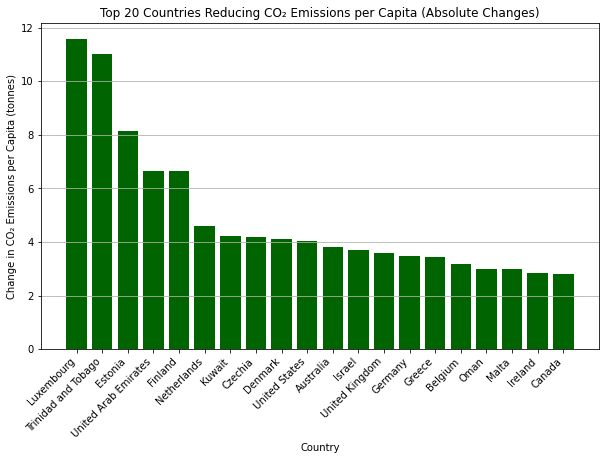

In [4]:

# Plot: Bar graph with change in CO2 per capita absolute values
# Top 10 countries by net score

plt.figure(figsize=(10, 6))
df_corr = df_changes_gdp.copy()
df_corr = df_corr.sort_values("delta_co2_per_capita").head(20)
bars = plt.bar(
    df_corr["country"],
    df_corr["delta_co2_per_capita"] * -1,
    color=[
        "darkGreen"
        for _, row in df_corr.iterrows()
    ]
)
plt.xlabel("Country")
plt.ylabel("Change in CO₂ Emissions per Capita (tonnes)")
plt.title("Top 20 Countries Reducing CO₂ Emissions per Capita (Absolute Changes)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.show()


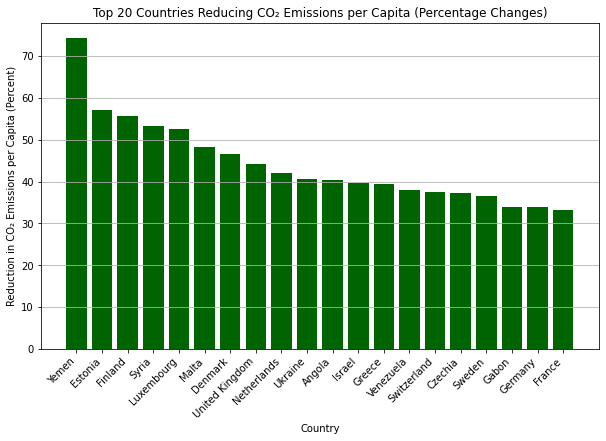

In [5]:

# Plot: Bar graph with change in CO2 per capita Percentage values
# Top 10 countries by net score

plt.figure(figsize=(10, 6))
df_corr = df_changes_gdp.copy()
df_corr = df_corr.sort_values("delta_co2_per_capita_pct").head(20)
bars = plt.bar(
    df_corr["country"],
    df_corr["delta_co2_per_capita_pct"] * -1,
    color=[
        "darkGreen"
        for _, row in df_corr.iterrows()
    ]
)
plt.xlabel("Country")
plt.ylabel("Reduction in CO₂ Emissions per Capita (Percent)")
plt.title("Top 20 Countries Reducing CO₂ Emissions per Capita (Percentage Changes)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.show()


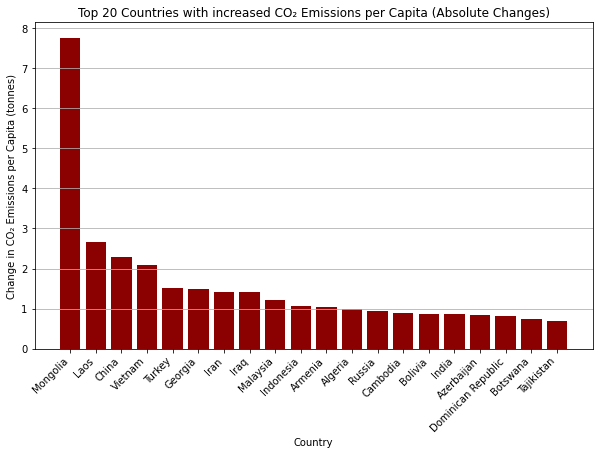

In [6]:

# Plot: Bar graph with change in CO2 per capita absolute values
# Worst 10 countries by net reduction in CO2 per capita

plt.figure(figsize=(10, 6))
df_corr = df_changes_gdp.copy()
df_corr = df_corr.sort_values("delta_co2_per_capita", ascending=False).head(20)
bars = plt.bar(
    df_corr["country"],
    df_corr["delta_co2_per_capita"],
    color=[
        "darkRed"
        for _, row in df_corr.iterrows()
    ]
)
plt.xlabel("Country")
plt.ylabel("Change in CO₂ Emissions per Capita (tonnes)")
plt.title("Top 20 Countries with increased CO₂ Emissions per Capita (Absolute Changes)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.show()

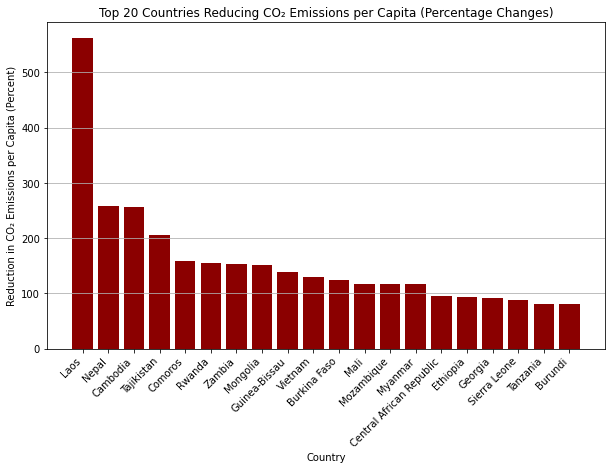

In [7]:

# Plot: Bar graph with change in CO2 per capita Percentage values
# Top 10 countries by net score

plt.figure(figsize=(10, 6))
df_corr = df_changes_gdp.copy()
df_corr = df_corr.sort_values("delta_co2_per_capita_pct",ascending=False).head(20)
bars = plt.bar(
    df_corr["country"],
    df_corr["delta_co2_per_capita_pct"] * 1,
    color=[
        "darkRed"
        for _, row in df_corr.iterrows()
    ]
)
plt.xlabel("Country")
plt.ylabel("Reduction in CO₂ Emissions per Capita (Percent)")
plt.title("Top 20 Countries Reducing CO₂ Emissions per Capita (Percentage Changes)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.show()


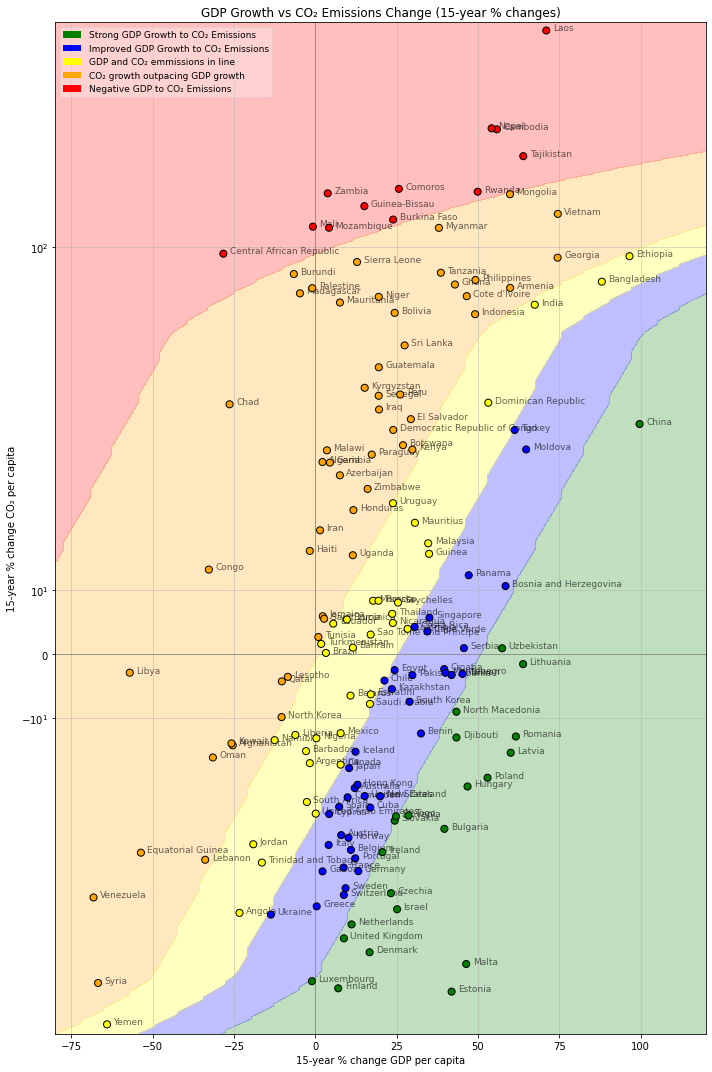

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from numpy import linspace, meshgrid
from matplotlib.colors import ListedColormap, BoundaryNorm

plt.figure(figsize=(10, 15))

x = linspace(-80, 120, 150)
y = linspace(-80, 600, 600)
X, Y = meshgrid(x, y)

#  desirability function with 5 regions
def custom_desirability(X, Y):
    Z = np.zeros_like(X)
    
    # Elite: X-Y > 50 (extreme decoupling)
    Z[X - Y > 50] = 50
    
    # Excellent: X-Y > 30
    Z[(X - Y > 25) & (X - Y <= 50)] = 65
    
    # Good: X-Y > 10
    Z[(X - Y > 0) & (X - Y <= 25)] = 75
    
    # Neutral: X-Y between -10 and 10
    Z[(X - Y >= -95) & (X - Y <= 0)] = 90
    
    # Poor: X-Y < -10
    Z[X - Y < -95] = 100
    
    return Z

Z = custom_desirability(X, Y)


z_levels = [0, 50, 65, 75, 90, 100]
your_colors = ['green', 'blue', 'yellow','orange', 'red' ] 

cmap = ListedColormap(your_colors)
norm = BoundaryNorm(z_levels, ncolors=6)

# Custom colored background
contour = plt.contourf(X, Y, Z, levels=z_levels, cmap=cmap, norm=norm, alpha=0.25)

colors = []
for _, row in df_changes_gdp.iterrows():
    if row["net_score"] > 50: colors.append("green")
    elif 50 > row["net_score"] > 25: colors.append("blue")
    elif 25 > row["net_score"] > 0: colors.append("yellow")
    elif 0 > row["net_score"] > -100: colors.append("orange")
    else: colors.append("red")

plt.scatter(df_changes_gdp["delta_gdp_per_capita_pct"], 
            df_changes_gdp["delta_co2_per_capita_pct"],
            c=colors, alpha=1, edgecolor="k", s=50, zorder=5)

# Rest unchanged
plt.axhline(0, color="grey", linewidth=1, alpha=0.7)
plt.axvline(0, color="grey", linewidth=1, alpha=0.7)

for _, row in df_changes_gdp.iterrows():
    plt.text(row["delta_gdp_per_capita_pct"] + 2, row["delta_co2_per_capita_pct"],
             row["country"], fontsize=9, alpha=0.6, ha='left')

plt.yscale('symlog', linthresh=50)
plt.xlabel("15-year % change GDP per capita")
plt.ylabel("15-year % change CO₂ per capita")
plt.title("GDP Growth vs CO₂ Emissions Change (15-year % changes)")
plt.grid(True, alpha=0.6)


legend_elements = [
    Patch(facecolor='green', label='Strong GDP Growth to CO₂ Emissions'),
    Patch(facecolor='blue', label='Improved GDP Growth to CO₂ Emissions'), 
    Patch(facecolor='yellow', label='GDP and CO₂ emmissions in line'),
    Patch(facecolor='orange', label='CO₂ growth outpacing GDP growth'),
    Patch(facecolor='red', label='Negative GDP to CO₂ Emissions'),
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=9, framealpha=0.3)
plt.tight_layout()
plt.show()
